<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

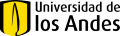

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Miniproyecto 3, Técnicas de *Deep Learning*: ...**

## **Descripción del Problema**

En este miniproyecto se plantea la **clasificación multi-clase** de artículos de noticias de la BBC aprovechando la capacidad de los modelos **transformer** para capturar relaciones contextuales complejas. Cada artículo puede pertenecer a una de varias categorías temáticas (e.g., Sport, Business, Politics, Tech).

## **Objetivo**

Desarrollar e implementar un modelo de clasificación multi-clase basado en transformers ( **BERT** y **RoBERTa**) que, tras un preprocesamiento del texto y la adaptación de la capa de salida, sea capaz de predecir con alta precisión, recall y F1-score las categorías de los artículos de la BBC. El modelo deberá entrenarse y evaluarse usando particiones de entrenamiento, validación y prueba, y reportar métricas detalladas por categoría.

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 13 de mayo de 2025.**



***
# **Índice**

El *notebook* aborda el proyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣. | **Instalación y carga de librerías** |
| 1️⃣.1️⃣. | **Word2Vec** |
| 1️⃣.2️⃣. | **GloVe** |
| 1️⃣.3️⃣. | **Configuraciones adicionales** |
| 2️⃣. | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣. | **Carga y estadísticas generales**       |
| 2️⃣.2️⃣. | **Limpieza de los datos**       |
| 3️⃣. | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣. | **Pipeline de preprocesamiento**   |
| 4️⃣. | **Desarrollo del modelo RNN**   |
| 4️⃣.1️⃣. | **Hiperparámetros, Partición y DataLoaders**   |
| 4️⃣.2️⃣. | **Definición del modelo**   |
| 4️⃣.3️⃣. | **Entrenamiento, validación y prueba**   |
| 5️⃣. | **Análisis de resultados y discusión**   |
| 5️⃣.1️⃣. | **Pruebas individuales del modelo**   |
| 6️⃣. | **Conclusión**   |
| 7️⃣. | **Referencias**   |


***

# 1. Instalación y carga de librerías

....

In [22]:
from __future__ import annotations

In [23]:
# Instalación de librerías necesarias para correr en Colab/Coursera
!pip -q install kagglehub langdetect matplotlib scikit-learn plotly

In [24]:

# Librerías comunes
import os, random, gc, time
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')
CHECKPOINT_PATH = "/content/drive/MyDrive/bert_checkpoints/best_bert.pt"

# Descarga de datasets y de embeddings
import kagglehub

# Limipieza y preparación de los txtos
from langdetect import detect, DetectorFactory
import re

# Preprocesamiento y herramientas de PLN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import (get_linear_schedule_with_warmup,
                          AutoTokenizer, AutoModelForSequenceClassification,)

# Modelado

from typing import List, Dict, Any
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import PreTrainedTokenizerBase
import torch.nn.functional as F


# Evaluación
from sklearn.metrics import (accuracy_score, f1_score,
                              precision_score,
                              recall_score,
                              classification_report)

# Librerías para visualizaciones
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Uses “bert-base-uncased” version of BERT, which is pre-trained on lower-cased English text

(with 12-layer, 768-hidden, 12-heads, 110M parameters)

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper: https://arxiv.org/pdf/1810.04805.pdf):

*   **Batch size:** 16, 32
*   **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
*   **Number of epochs:** 2, 3, 4

[1]

In [25]:
#Parámetros globales de los modelos
TEXT_COL   = "text"
LABEL_COL  = "labels"                    # columna con la categoría en texto
MAX_LEN    = 256
BATCH_SIZE = 16
EPOCHS     = 5
PATIENCE   = 2
UNFREEZE_PER_EPOCH = 2                 # capas a liberar por época
SEED = 13

Se descarga el conjunto de datos de reseñas de noticias de la BBC de **`kagglehub`**. La función **`dataset_download`** guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

## 1.3. Configuraciones adicionales

Con el siguiente bloque se detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  

Primero se llama a **`is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al *runtime* de Colab. Según el resultado se imprime un mensaje informativo. Posteriormente, se construye el objeto **`device`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [26]:
# Devuelve asignación de GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo activo → {DEVICE}")

Dispositivo activo → cpu


Adicionalmente se ocultan avisos para mantener limpias algunas salidas del notebook; y se imprimen las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`scikit-learn`**, **`kagglehub`**, **`matplotlib`**). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [27]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ["numpy", "pandas", "torch", "scikit-learn", "kagglehub","matplotlib"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
matplotlib :  3.10.0


Finalmente, para cerrar esta sección se configuran algunas semillas para tener cierto grado de control en la aleatoriedad.

In [28]:
# Definición del random state y seeds

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [29]:
# Leer el conjunto de datos y cargarlo a un dataframe

# Descarga del conjunto de datos
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
print("Datos descargados en:", path)

CSV_PATH = os.path.join(path, "bbc_news_text_complexity_summarization.csv")
print(f"Dataset descargado en: {CSV_PATH}")

data_raw = pd.read_csv(CSV_PATH)
print("Filas totales:", len(data_raw))

Datos descargados en: /kaggle/input/bbc-articles-dataset
Dataset descargado en: /kaggle/input/bbc-articles-dataset/bbc_news_text_complexity_summarization.csv
Filas totales: 2127


***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

In [30]:
data_raw.isna().sum()

,0
text,0
labels,0
no_sentences,0
Flesch Reading Ease Score,0
Dale-Chall Readability Score,0
text_rank_summary,0
lsa_summary,0


In [31]:
data_raw.duplicated().sum()

np.int64(0)

In [32]:
df = data_raw.copy()

In [33]:
# 2.1. Carga y estadísticas  ➜  justo después de copiar el DataFrame

le = LabelEncoder()
df["label_id"] = le.fit_transform(df[LABEL_COL])

NUM_LABELS = len(le.classes_)      # 👈  siempre un entero

id2label = {i: lbl for i, lbl in enumerate(le.classes_)}
label2id = {v: k for k, v in id2label.items()}

In [34]:
# Gráfica para mostrar distribución de las clases
def plot_class_distribution(df: pd.DataFrame,
                            label_col: str = "label_id",
                            class_names: list[str] | None = None) -> None:
    """
    Grafica la distribución de las clases en el DataFrame.
    - df: DataFrame con la columna de etiquetas.
    - label_col: nombre de la columna numérica de etiquetas.
    - class_names: lista de nombres de clase en orden de los IDs.
    """
    counts = df[label_col].value_counts().sort_index()
    # Si no se proveen nombres, utilizamos los índices numéricos
    labels = class_names if class_names is not None else counts.index.astype(str)

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts.values)
    plt.xlabel("Clase")
    plt.ylabel("Número de artículos")
    plt.title("Distribución de clases en el dataset")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Llamada de ejemplo sobre todo el dataset
plot_class_distribution(df,
                        label_col="label_id",
                        class_names=le.classes_.tolist())

In [35]:
def detectar_idiomas(df: pd.DataFrame,
                     col_texto: str = 'text') -> pd.DataFrame:
    """
    Detecta el idioma de cada fila en la columna **col_texto**,
    añade la columna **idioma** y muestra ejemplos no ingleses.
    """
    # Inicializamos con 'desconocido'
    df['idioma'] = 'desconocido'

    # Función auxiliar segura
    def _detectar(texto):
        if isinstance(texto, str) and texto.strip():
            try:
                return detect(texto)
            except Exception:
                return 'desconocido'
        return 'desconocido'

    # Aplicamos detección
    df['idioma'] = df[col_texto].apply(_detectar)

    # Filtramos los que no son inglés
    mask = df['idioma'] != 'en'
    idx_no_en = df[mask].index

    if len(idx_no_en) > 0:
        print(f"Se encontraron {len(idx_no_en)} textos NO en inglés (ejemplos):")
        # Mostramos hasta 5 ejemplos
        for i in idx_no_en[:5]:
            print(f" • Índice {i}: [{df.at[i,'idioma']}] {df.at[i,col_texto][:100]}...")
    else:
        print("Todos los textos están detectados como inglés.")

    return df

Nota: En algunas ocasiones, la función `detect` confunde la presencia de nombres propios o pequeñas secciones en otros idiomas como un indicativo de que el texto no está en inglés. Sin embargo, estas ocurrencias suelen ser mínimas o nulas.

Detectando otros idiomas:

In [36]:
df = detectar_idiomas(df, col_texto='text')

Todos los textos están detectados como inglés.


***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

....

In [37]:
# Limpieza básica
def clean_text(text: str) -> str:
    text = re.sub(r"\s+", " ", text)            # colapsar whitespace
    text = re.sub(r"[^\w.,;:!?()¿¡ ]+", "", text)
    return text.strip()

for col in ("text", "text_rank_summary", "lsa_summary"):
    if col in df.columns:
        df[col] = df[col].astype(str).apply(clean_text)


In [38]:
train_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df["label_id"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.10, stratify=train_df["label_id"], random_state=SEED
)
print("Tamaños – Train / Val / Test:", len(train_df), len(val_df), len(test_df))

Tamaños – Train / Val / Test: 1722 192 213


[2]

***

# 4. Desarrollo del modelo RNN

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

AutoTokenizer	Cuando tu pipeline puede alternar entre arquitecturas (BERT, RoBERTa, DistilBERT…) o quieres mantener el código genérico.  
+ Detecta internamente la clase correcta ( BertTokenizerFast, RobertaTokenizerFast …).
+ Un único import.
+ Reduce “if/else” en tu código.
− Ligeramente más sobrecarga al resolver la clase la primera vez (irrelevante en la práctica).

¿Dónde está la “preparación de secuencias” en tu código?
El punto exacto aparece dentro del método __getitem__ de la clase BBCDataset (alrededor de la mitad del archivo mini_proyecto_3_dl.py). Allí se llama al tokenizer para convertir cada artículo en la representación numérica que entiende BERT/RoBERTa:

Tokenización
AutoTokenizer descompone el texto en sub-palabras según el vocabulario del modelo (WordPiece para BERT, Byte-Pair para RoBERTa, etc.). También añade los special tokens [CLS] y [SEP] que marcan inicio y fin de la secuencia.

Conversión a IDs
Cada token se mapea a un entero (input_ids) que luego se transformará en embeddings dentro del modelo.

Máscara de atención
Se crea attention_mask, un vector 1/0 que indica cuáles posiciones son texto real y cuáles son padding.

Truncado y padding
Con truncation=True y padding="max_length" el texto se corta si supera MAX_LEN (256) y se rellena con ceros hasta ese mismo largo, garantizando que todos los ejemplos midan lo mismo y puedan apilarse en un batch.

Empaquetado en tensores PyTorch
return_tensors="pt" devuelve cada parte como un tensor; luego squeeze(0) elimina la dimensión de tamaño 1 añadida por el tokenizer para facilitar el batching posterior.

En conjunto, este bloque es el “preparador de secuencias”: convierte texto crudo en el lote de tensores (input_ids, attention_mask, y opcionalmente token_type_ids) que el encoder transformer necesita para producir embeddings y, finalmente, la predicción de clase.

In [39]:
# -----------------------------------------------------
#  BBCDataset   (misma lógica, solo un par de detalles)
# -----------------------------------------------------
class BBCDataset(Dataset):
    """
    Dataset para la clasificación BBC.
    • Mantiene tokenización con el tokenizer recibido (AutoTokenizer).
    • Devuelve exactamente las mismas claves que antes:
        input_ids / attention_mask / (token_type_ids) / labels
    • Opción `return_idx` por si en algún análisis necesitas
      recuperar el índice original; por defecto NO cambia nada.
    """
    def __init__(self, df, tokenizer, max_len, *, return_idx: bool = False):
        self.texts  = df[TEXT_COL].tolist()
        self.labels = df["label_id"].tolist()
        self.tok    = tokenizer
        self.max_len = max_len
        self.return_idx = return_idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        item["text"] = self.texts[idx]
        if self.return_idx:
            item["idx"] = torch.tensor(idx)   # ← opcional, no molesta al resto
        return item

In [40]:
def collate_with_text(batch):
    texts  = [b.pop("text") for b in batch]
    keys   = batch[0].keys()          # input_ids, attention_mask, labels, …
    out    = {k: torch.stack([b[k] for b in batch]) for k in keys}
    out["text"] = texts               # vuelve a incluir texto
    if "idx" in batch[0]:
        out["idx"] = torch.stack([b["idx"] for b in batch])
    return out

In [41]:
def make_loader(df, tokenizer, split, batch_size, max_len,
                *, return_idx=False, num_workers=2):
    ds = BBCDataset(df, tokenizer, max_len, return_idx=return_idx)
    return DataLoader(
        ds, batch_size=batch_size, shuffle=(split=="train"),
        num_workers=num_workers, pin_memory=True,
        collate_fn=collate_with_text                     #  ←  nuevo
    )

In [42]:
def freeze_layers(model,
                  *,
                  freeze: bool = True,
                  last_n: int | None = None) -> None:
    """
    Congela/descongela capas del encoder de un modelo *transformers*.

    Parámetros
    ----------
    model   : instancia de AutoModelForSequenceClassification
    freeze  : si *True* congela; si *False* descongela.
    last_n  :  • None  ➜ aplica a **todo** el encoder
               • int   ➜ afecta solo a las *n* últimas capas

    Ejemplos
    --------
    # 1) Congelar todo el encoder
    freeze_layers(model)                       # freeze=True, last_n=None

    # 2) Descongelar las 4 últimas capas
    freeze_layers(model, freeze=False, last_n=4)

    # 3) Congelar todo excepto las 2 últimas capas
    freeze_layers(model, freeze=True,  last_n=2)
    """
    # 1) Hay modelos (e.g., DistilBERT) donde el encoder vive en .transformer
    encoder = getattr(model.base_model, "encoder", None) \
              or getattr(model.base_model, "transformer", None)

    if encoder is None:            # fallback genérico
        for p in model.base_model.parameters():
            p.requires_grad = not freeze if last_n is None else p.requires_grad
        return

    layers = list(encoder.layer)
    if last_n is None:
        # Congela o descongela todo el encoder
        for p in encoder.parameters():
            p.requires_grad = not freeze
    else:
        # Asegura que last_n no exceda el número total de capas
        last_n = max(0, min(last_n, len(layers)))

        # 2) Definir subconjuntos
        affected = layers[-last_n:]           # capas que cambian
        unaffected = layers[:-last_n]         # capas que se mantienen

        # 3) Aplicar flags
        for layer in affected:
            for p in layer.parameters():
                p.requires_grad = not freeze if freeze else True

        if freeze:                            # solo cuando queremos congelar
            for layer in unaffected:
                for p in layer.parameters():
                    p.requires_grad = False

In [43]:
# 3) predict_proba  ➜  decorador
@torch.no_grad()
def predict_proba(model, batch, *, device):
    """
    Devuelve las probabilidades (softmax) para un batch.
    ➜ batch: dict con input_ids, attention_mask, (token_type_ids)
    """
    model.eval()
    inputs = {k: v.to(device) for k, v in batch.items()
              if k not in ["labels", "text", "idx"]}
    logits = model(**inputs).logits           # (B, num_labels)
    probs  = F.softmax(logits, dim=-1)
    return probs.cpu()

In [1]:
# -----------------------------------------------------
# 4. Función train_and_evaluate  >>> MODIFIED <<<
# -----------------------------------------------------


def train_and_evaluate(model_name: str, train_df, val_df, test_df):
    print(f"\n========== Entrenando {model_name} ==========")

    start = time.time()
    # Tokenizer + modelo
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id,
    ).to(DEVICE)

    # 5.1 Congelar encoder completo y luego liberar gradualmente
    freeze_layers(model)

    # 5.2 Pesos de clase balanceados
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.arange(NUM_LABELS), y=train_df["label_id"]
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

    # 5.3 DataLoaders
    loaders = {
        "train": make_loader(train_df, tokenizer, "train", BATCH_SIZE, MAX_LEN),
        "val":   make_loader(val_df,   tokenizer, "val",   BATCH_SIZE, MAX_LEN),
        "test":  make_loader(test_df,  tokenizer, "test",  BATCH_SIZE, MAX_LEN),
    }

    # 5.4 Optimizador & scheduler
    total_steps = len(loaders["train"]) * EPOCHS
    optimizer   = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
    scheduler   = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.06 * total_steps),
        num_training_steps=total_steps,
    )

    criterion   = torch.nn.CrossEntropyLoss(weight=class_weights)

    best_f1, patience_cnt = 0.0, 0
    best_path = f"best_{model_name.split('-')[0]}_bbc.pt"

    def epoch_pass(split):
        is_train = split == "train"
        model.train() if is_train else model.eval()
        losses, preds_all, trues_all = [], [], []

        for batch in loaders[split]:
            batch = {k: (v.to(DEVICE) if torch.is_tensor(v) else v) for k,v in batch.items()}
            with torch.set_grad_enabled(is_train):
                inputs = {k: v for k, v in batch.items() if k not in ["labels", "text", "idx"]}
                outputs = model(**inputs)
                loss = criterion(outputs.logits, batch["labels"])
                if is_train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step(); scheduler.step(); optimizer.zero_grad()

            losses.append(loss.item())
            preds_all.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
            trues_all.extend(batch["labels"].cpu().numpy())

        acc = accuracy_score(trues_all, preds_all)
        f1m = f1_score(trues_all, preds_all, average="macro", zero_division=0)
        f1µ = f1_score(trues_all, preds_all, average="micro", zero_division=0)
        return np.mean(losses), acc, f1m, f1µ

    # 5.5 Entrenamiento
    hist = {k: [] for k in ["epoch","train_loss","val_loss",
                        "train_acc","val_acc","train_f1","val_f1"]}
    for epoch in range(1, EPOCHS + 1):
        freeze_layers(model, freeze=False,last_n=epoch * UNFREEZE_PER_EPOCH)
        train_loss, train_acc, train_f1m, train_f1µ = epoch_pass("train")
        val_loss,   val_acc,   val_f1m,   val_f1µ   = epoch_pass("val")
        hist["epoch"].append(epoch)
        hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)
        hist["train_acc"].append(train_acc);   hist["val_acc"].append(val_acc)
        hist["train_f1"].append(train_f1m);    hist["val_f1"].append(val_f1m)

        print(f"Ep {epoch:02d}: \tTL {train_loss:.4f} / VL {val_loss:.4f} | "
              f"F1_macro {val_f1m:.3f}  Acc {val_acc:.3f}")

        if val_f1m > best_f1:
            best_f1 = val_f1m
            patience_cnt = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience_cnt += 1
            if patience_cnt == PATIENCE:
                print("Early stopping ↯\n")
                break

    # 5.6 Evaluación sobre *test*
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc, test_f1m, test_f1µ = epoch_pass("test")

    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in loaders["test"]:
            batch = {k: (v.to(DEVICE) if torch.is_tensor(v) else v) for k,v in batch.items()}
            inputs = {k: v for k, v in batch.items() if k not in ["labels", "text", "idx"]}
            outputs = model(**inputs)
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    # Precisión y recall (macro / micro)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    prec_micro = precision_score(y_true, y_pred, average="micro", zero_division=0)
    rec_macro  = recall_score   (y_true, y_pred, average="macro", zero_division=0)
    rec_micro  = recall_score   (y_true, y_pred, average="micro", zero_division=0)

    report = classification_report(
        y_true,
        y_pred,
        labels=list(range(NUM_LABELS)),
        target_names=le.classes_.tolist(),
        digits=3,
        zero_division=0,
    )

    # 5.7 Limpieza explícita
    test_loader_ref = loaders["test"]    # referencia antes de borrar
    del loaders, optimizer, scheduler, criterion
    gc.collect(); torch.cuda.empty_cache()

    metrics: dict[str, Any] = {
        "model": model_name,
        "test_acc":        test_acc,
        "test_precision_macro": prec_macro,
        "test_precision_micro": prec_micro,
        "test_recall_macro":    rec_macro,
        "test_recall_micro":    rec_micro,
        "test_f1_macro":        test_f1m,
        "test_f1_micro":        test_f1µ,
        "report":  report,          # classification_report
        "history": hist,            # losses / accuracies por época
        # --- NUEVO ---
        "trained_model": model,     # para análisis posterior
        "test_loader": test_loader_ref  } # coherente

    print(f"\n⏱ Duración total: {(time.time()-start)/60:.1f} min")
    return metrics, model, tokenizer, test_loader_ref , hist

....

***

## 4.3. Entrenamiento, validación y prueba

 **`gradient clipping`** m

In [ ]:
if __name__ == "__main__":
    start_main = time.time()          # ← aquí
    MODELS = {
        "bert-base-uncased": "BERT",
        "roberta-base": "RoBERTa",
    }

    results =[]
    models, loaders, histories = {}, {}, {}
    for mdl_name, label in MODELS.items():
        m, mol, tok, tl, h  = train_and_evaluate(mdl_name, train_df, val_df, test_df)
        results.append(m)
        models[mdl_name]   = m
        loaders[mdl_name]  = tl
        histories[mdl_name]= h
        print("\n>>> Reporte detallado")
        print(m["report"])
        print("="*60)

    # tabla comparativa
    print("\n======= Comparativa final =======")
    for res in results:
        print(f"{MODELS[res['model']]:9s} | "
        f"Acc {res['test_acc']:.3f} | "
        f"P_macro {res['test_precision_macro']:.3f} | "
        f"R_macro {res['test_recall_macro']:.3f} | "
        f"F1_macro {res['test_f1_macro']:.3f}")

    dur = (time.time() - start_main) / 60
    print(f"\nTiempo total: {dur:.1f} min\n")


========== Entrenando bert-base-uncased ==========


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Métrica	¿Cómo se calcula?	Cuándo aporta valor	Observaciones para tu proyecto (BBC News, 5 clases)
Micro-precision/recall/F1	Suma todos los TP, FP, FN y calcula la razón una sola vez.	• Multi-label (muchas etiquetas por muestra).
• Conjuntos muy desbalanceados donde el “tamaño” total importa (p. ej., métricas de search).	Para clasificación single-label multi-clase, el micro-F1 coincide con la accuracy. Si ya reportas accuracy, el micro-F1 añade poca información nueva.
Macro-precision/recall/F1	Calcula la métrica por clase y luego hace el promedio simple (no ponderado).	• Quieres ver si el modelo trata a todas las clases por igual.
• Dataset algo desbalanceado.
• Necesitas comparación justa entre modelos cuando hay minorías.	Útil incluso con BBC (distribución ≈ balanceada, pero nunca perfecta) para evidenciar si alguna categoría -“tech”, “sport”…- se queda atrás.

[3]

...

***


# 5. Análisis de resultados y discusión

...

...

In [ ]:
def plot_model_diagnostics(*,
                            history: dict | None = None,
                            model = None,
                            test_loader = None,
                            class_names: list[str] | None = None,
                            device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                            title: str = "") -> None:
    """
    Combina en una sola figura:
       • Curvas de Loss y Accuracy (si se pasa `history`)
       • Matriz de confusión        (si se pasa `model` + `test_loader`)
    Puedes suministrar solo una de las dos partes si lo prefieres.

    Parámetros
    ----------
    history      : dict con claves 'train_loss', 'val_loss', 'train_acc', 'val_acc'
    model        : modelo transformers ya entrenado
    test_loader  : DataLoader con el set de test
    class_names  : lista de etiquetas (str) en el mismo orden que los IDs
    device       : cpu / cuda
    title        : título base que se antepone a cada sub-gráfico
    """
    # ------ determinar cuántas filas de subplots necesitamos ------
    n_rows = 0
    if history is not None:
        n_rows += 2                # Loss y Accuracy
    if model is not None and test_loader is not None and class_names is not None:
        n_rows += 1                # Matriz de confusión
    if n_rows == 0:
        raise ValueError("Debes pasar `history` o (`model`, `test_loader`, `class_names`).")

    plt.figure(figsize=(7, 4 * n_rows))
    plot_idx = 1

    # ------ curvas de entrenamiento ------------------------------
    if history is not None:
        epochs = range(1, len(history["train_loss"]) + 1)

        # Loss
        plt.subplot(n_rows, 1, plot_idx)
        plt.plot(epochs, history["train_loss"], label="Train Loss")
        plt.plot(epochs, history["val_loss"],   label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{title} – Loss")
        plt.legend()
        plot_idx += 1

        # Accuracy
        plt.subplot(n_rows, 1, plot_idx)
        plt.plot(epochs, history["train_acc"], label="Train Acc")
        plt.plot(epochs, history["val_acc"],   label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title} – Accuracy")
        plt.legend()
        plot_idx += 1

    # ------ matriz de confusión ----------------------------------
    if model is not None and test_loader is not None and class_names is not None:
        model.eval()
        y_true, y_pred = [], []

        with torch.no_grad():
            for batch in test_loader:
                # ← el DataLoader sigue entregando las mismas claves que antes
                labels = batch["labels"]
                inputs = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "text", "idx"]}

                logits = model(**inputs).logits
                probs = F.softmax(logits, dim=-1)
                preds = torch.argmax(probs, dim=1)

                y_true.extend(labels.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())

        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(n_rows, 1, plot_idx)
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
        disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
        plt.title(f"{title} – Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_model_diagnostics(
    history     = histories["bert-base-uncased"],
    model       = models["bert-base-uncased"],
    test_loader = loaders["bert-base-uncased"],
    class_names = le.classes_.tolist(),
    title       = "BERT"
)

plot_model_diagnostics(
    history     = histories["roberta-base"],
    model       = models["roberta-base"],
    test_loader = loaders["roberta-base"],
    class_names = le.classes_.tolist(),
    title       = "RoBERTa"
)

In [ ]:
# -----------------------------------------------------
#  Ejemplos FN / FP por clase  (código simplificado)
# -----------------------------------------------------
def collect_fn_fp_examples(model,
                            test_loader,
                            test_df,
                            class_names: list[str],
                            *,
                            device=DEVICE,
                            k: int = 5) -> pd.DataFrame:
    """
    Devuelve un DataFrame con **hasta `k`** ejemplos *FN* y *FP*
    por clase, además de los *TP* para referencia.

    Columnas devueltas:
      ├─ text     : texto original
      ├─ true     : etiqueta real         (int)
      ├─ pred     : etiqueta predicha     (int)
      └─ type     : 'TP' ‖ 'FN' ‖ 'FP'
    """
    model.eval()
    texts, y_true, y_pred = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            labels = batch["labels"]
            inputs = {k:v.to(device) for k,v in batch.items()
                      if k not in ["labels","text","idx"]}
            logits = model(**inputs).logits
            probs  = F.softmax(logits, dim=-1)
            preds  = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            texts.extend(batch["text"])
    # --- DataFrame --------------------------------------------------------
    df = pd.DataFrame({
        "text": texts,
        "true": y_true,
        "pred": y_pred,
    })
    df["type"] = "UNDEF"
    # --- Etiquetar tipo de acierto/error ----------------------------------

    # --- Seleccionar hasta k ejemplos por clase y tipo --------------------
    out_rows = []
    rows=[]
    for cls in range(len(class_names)):
        df.loc[(df.true==cls) & (df.pred!=cls), "type"] = "FN"
        df.loc[(df.pred==cls) & (df.true!=cls), "type"] = "FP"
        df.loc[(df.true==cls) & (df.pred==cls), "type"] = "TP"
        fn = df[(df.true==cls)&(df.pred!=cls)].head(k)
        fp = df[(df.pred==cls)&(df.true!=cls)].head(k)
        rows.extend(fn.assign(tipo="FN", clase=class_names[cls]).to_dict("records"))
        rows.extend(fp.assign(tipo="FP", clase=class_names[cls]).to_dict("records"))
    return pd.DataFrame(rows)

In [ ]:
# 1) Corre primero la inferencia sobre test_loader
df_err_bert = collect_fn_fp_examples(models["BERT"], test_loader,
                                     test_df, le.classes_.tolist(), k=3)

df_err_roberta = collect_fn_fp_examples(models["RoBERTa"], test_loader,
                                     test_df, le.classes_.tolist(), k=3)
# 2) Visualiza
display(df_err_bert[["text","true","pred","tipo"]].head(10))
display(df_err_roberta[["text","true","pred","tipo"]].head(10))

In [ ]:
def tsne_cls(*,
             model,
             test_loader,
             class_names,
             device,
             save_path: str | None = None):
    """
    • Extrae embeddings [CLS] del modelo sobre `test_loader`.
    • Ejecuta t-SNE en 2 D con perplexity adaptativa:
          perplexity = min(40, n_samples // 10)
    • Si existe `save_path` y el archivo está creado,
      reutiliza los embeddings proyectados (ahorra **`time`**).
    """
    # ------------ 1) Obtener o cargar los vectores ----------------
    if save_path and os.path.isfile(save_path):
        print(f"✔  t-SNE cargado de {save_path}")
        data = np.load(save_path)
        X_2d, y = data[:, :2], data[:, 2].astype(int)
    else:
        model.eval()
        reps, labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                inputs = {k: v.to(device) for k, v in batch.items()
                          if k not in ["labels", "text"]}
                out = model(**inputs, output_hidden_states=True)
                cls = out.hidden_states[-1][:, 0, :]      # (B, H)

                reps.append(cls.cpu())
                labels.extend(batch["labels"].tolist())

        X = torch.cat(reps).numpy()
        y = np.array(labels)

        # ------------ 2) t-SNE con perplexity dinámica ------------
        n_samples   = X.shape[0]
        perplexity  = max(5, min(40, n_samples // 10))
        print(f"→ n_samples={n_samples} | perplexity={perplexity}")

        tsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            init="random",
            learning_rate="auto",
            random_state=42,
            n_iter=1000
        )
        X_2d = tsne.fit_transform(X)

        if save_path:
            np.save(save_path, np.c_[X_2d, y])
            print(f"💾  Guardado en {save_path}")

    # ------------ 3) Graficar ------------------------------------
    plt.figure(figsize=(6, 5))
    for cls_id, cls_name in enumerate(class_names):
        pts = X_2d[y == cls_id]
        plt.scatter(pts[:, 0], pts[:, 1], alpha=0.6, label=cls_name, s=15)

    plt.title("t-SNE de embeddings CLS")
    plt.axis("off")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [ ]:
# 1) Escoge el modelo que quieres proyectar
model_to_plot = models["BERT"]     # o "RoBERTa"

# 2) Ejecución (reutiliza si ya existe 'tsne_cls.npy')
tsne_cls(
    model       = model_to_plot,
    test_loader = test_loader,
    class_names = le.classes_.tolist(),
    device      = DEVICE,
    save_path   = Path("tsne_cls.npy")          # guarda para futuras corridas
)

***


# 6. Conclusión

.....

***


# 7. Referencias

[1] **BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding  Google AI Language**  
Disponible en: [arxiv.org](https://arxiv.org/abs/1810.04805)


[2] **Documents Classification using BERT on BBC Dataset**  
Disponible en: [kaggle.com](https://www.kaggle.com/code/ouardasakram/documents-classification-using-bert-on-bbc-dataset)


[3] **Bert-Classification-BBC-News**  
Disponible en: [github.com](https://github.com/bymi15/Bert-Classification-BBC-News/blob/main/bert_classification_bbc_news.ipynb)


